In [13]:
import os
import io
import numpy as np
import gridfs
from pymongo import MongoClient
import cv2
import matplotlib.pyplot as plt

In [14]:
mongo_client = MongoClient('localhost', 27017)
db = mongo_client['bigdata']
collection = db['processed_images']
fs = gridfs.GridFS(db)


In [15]:
COLORS = {
    0: [0, 0, 0],          # Black: Background
    1: [255, 0, 0],        # Red: Building-flooded
    2: [0, 255, 0],        # Green: Building-non-flooded
    3: [0, 0, 255],        # Blue: Road-flooded
    4: [255, 255, 0],      # Yellow: Road-non-flooded
    5: [0, 255, 255],      # Cyan: Water
    6: [255, 0, 255],      # Magenta: Tree
    7: [128, 0, 128],      # Purple: Vehicle
    8: [0, 128, 128],      # Teal: Pool
    9: [128, 128, 0],      # Olive: Grass
}

def read_mask(image_id):
    try:
        # Find the document by image_id
        image_doc = collection.find_one({"image_id": image_id}, sort=[('_id', -1)])
        if not image_doc:
            print(f"No document found with image_id: {image_id}")
            return None

        # Retrieve the mask GridFS ID
        mask_gridfs_id = image_doc["mask_gridfs_id"]

        # Read the mask data from GridFS
        mask_bytes = fs.get(mask_gridfs_id).read()
        mask = np.load(io.BytesIO(mask_bytes))

        return mask

    except Exception as e:
        print(f"Error reading mask for image {image_id}: {e}")
        return None

Mask for image 7420 retrieved successfully.


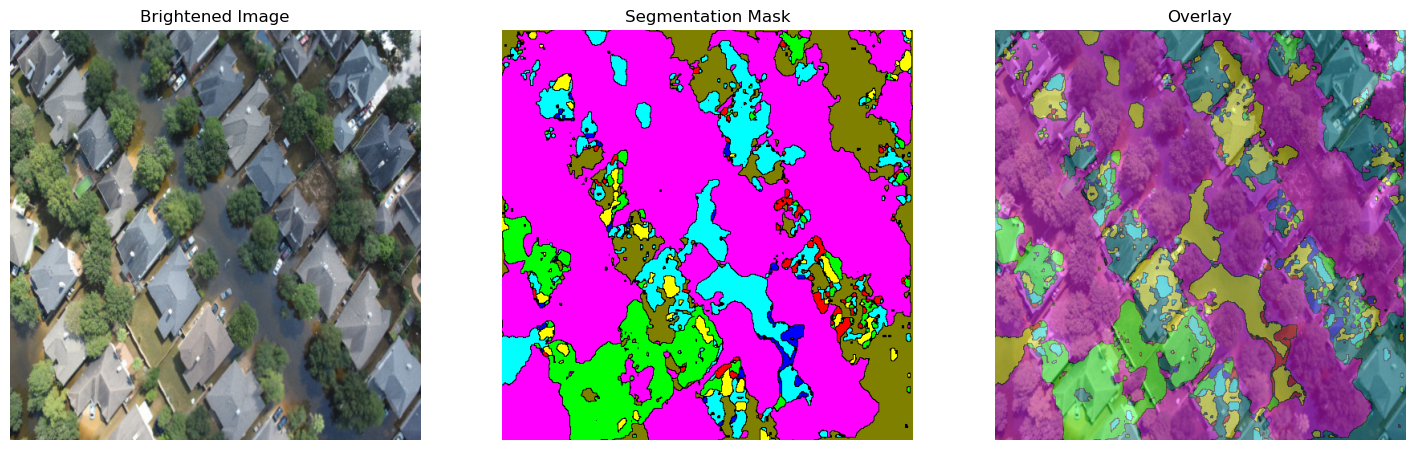

In [16]:
# Example usage
image_id = '7420'  # Replace with the actual image ID you want to retrieve
mask = read_mask(image_id)
if mask is None:
    print(f"Failed to retrieve mask for image {image_id}.")
else:
    print(f"Mask for image {image_id} retrieved successfully.")

    # Read the brightened image
    bright_image_path = f'./test/image/{image_id}.jpg'  # Adjust this path as needed
    bright_image = cv2.imread(bright_image_path)

    if bright_image is None:
        raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

    # Create an RGB image from the grayscale mask
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Apply colors to the mask
    for class_id, color in COLORS.items():
        colored_mask[mask == class_id] = color

    # Resize the colored mask to match the dimensions of the brightened image
    colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

    # Blend the brightened original image with the resized colored mask
    alpha_blend = 0.6  # Transparency factor for blending
    blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

    # Display the images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Brightened Image')
    plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Segmentation Mask')
    plt.imshow(colored_mask_resized)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Overlay')
    plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()